## Project 1 - Population Prediction for 2122
Authors:
Riley Galante,
William Chan,
Tony Tang

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import statsmodels as sm

In [2]:
url = 'https://raw.githubusercontent.com/tcy98/colabDataStoreage/main/population_total_long.csv'
df = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12595 entries, 0 to 12594
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  12595 non-null  object
 1   Year          12595 non-null  int64 
 2   Count         12595 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 295.3+ KB


The population dataset from 1960-2017 is loaded in above. For our analysis, we only need the total count for each year, not the total count for each country, each year.

In [3]:
df[df.Year == 1960].Count.sum()

3019770047

This is how we will get the total population value for each year. We sum the count value for each country in a given year.

In [4]:
population_dict = {1960: 3019770047}
year = 1961
while year <= 2017:
  total_pop = df[df.Year == year].Count.sum()
  population_dict.update({year: total_pop})
  year+=1
df_updated = pd.DataFrame(list(population_dict.items()),columns = ['Year','Count']) 
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    58 non-null     int64
 1   Count   58 non-null     int64
dtypes: int64(2)
memory usage: 1.0 KB


Now that the updated dataframe has been created with the necessary information, time to visualize.

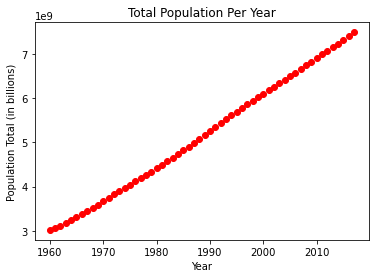

In [5]:
plt.plot(df_updated.Year, df_updated.Count, 'ro')
plt.xlabel("Year")
plt.ylabel("Population Total (in billions)")
plt.title("Total Population Per Year")
plt.show()

After visualizing the data, it appears that the trend is relatively linear in the past 60 years. It is important to note that if we had more data from much earlier in time, this trend would most likely be exponential. However, we feel that if we used more data and got the exponential trend, it might influence our model to overestimate the 2122 total population. Especially considering the conclusions of many scientists that the Earth has a maximum capacity for human life that we are quickly approaching, this dataset works better for a more realistic prediction.

Since the data has a linear trend, we will use a linear regression model to start.

In [6]:
#80-20 train test split
X_train, X_test, y_train, y_test = train_test_split(df_updated.Year, df_updated.Count, test_size=0.2, random_state=0)

#reshape X values to match parameter requirements of linreg
arr = X_train.values  
X_train = arr.reshape((-1,1))
arr = X_test.values
X_test = arr.reshape((-1,1))

#Fit the model with training data
linreg = LinearRegression().fit(X_train, y_train)

#predict the y_test values using x_test and analyze performance
y_pred = linreg.predict(X_test)
accuracy = r2_score(y_test, y_pred)
print("Score: ", accuracy)

Score:  0.9990664712630442


In the cell above, a train test split was used to determine if linear regression is a good model for the dataset. It is evident that the model fits the data in that the R2 score is really good, meaning the predicted total population values in the test set are very close to the true population values.

In [7]:
X = df_updated.Year
y = df_updated.Count

#reshape X values to match parameter requirements of linreg
arr = X.values  
X = arr.reshape((-1,1))

#Fit model with full dataset
linreg = LinearRegression().fit(X, y)

X_predict = np.array([2122])
X_predict = X_predict.reshape((-1,1))

#get 2122 prediction
linreg_prediction = linreg.predict(X_predict)

print("Total Population in 2122:" , "{:.0f}".format(linreg_prediction[0]))

Total Population in 2122: 15895926083


Linear Regression estimates a population of about 15.9 billion according to the current trend in population growth. This number is likely skewed because we did not have population data available from the past few years in this dataset. Thus, this estimate does not take into account the affect of COVID-19 on the population. Also, as mentioned before, scientists believe there is a cap on the number of humans the earth can support. Currently, that number is at about 9-10 billion, which contradicts our estimate.

Apply ARIMA model with statsmodels library

The parameters of the ARIMA model are defined as follows:



*   p: The number of lag observations included in the model, also called the lag order. 
*   d: The number of times that the raw observations are differenced, also called the degree of differencing.
*   q: The size of the moving average window, also called the order of moving average.








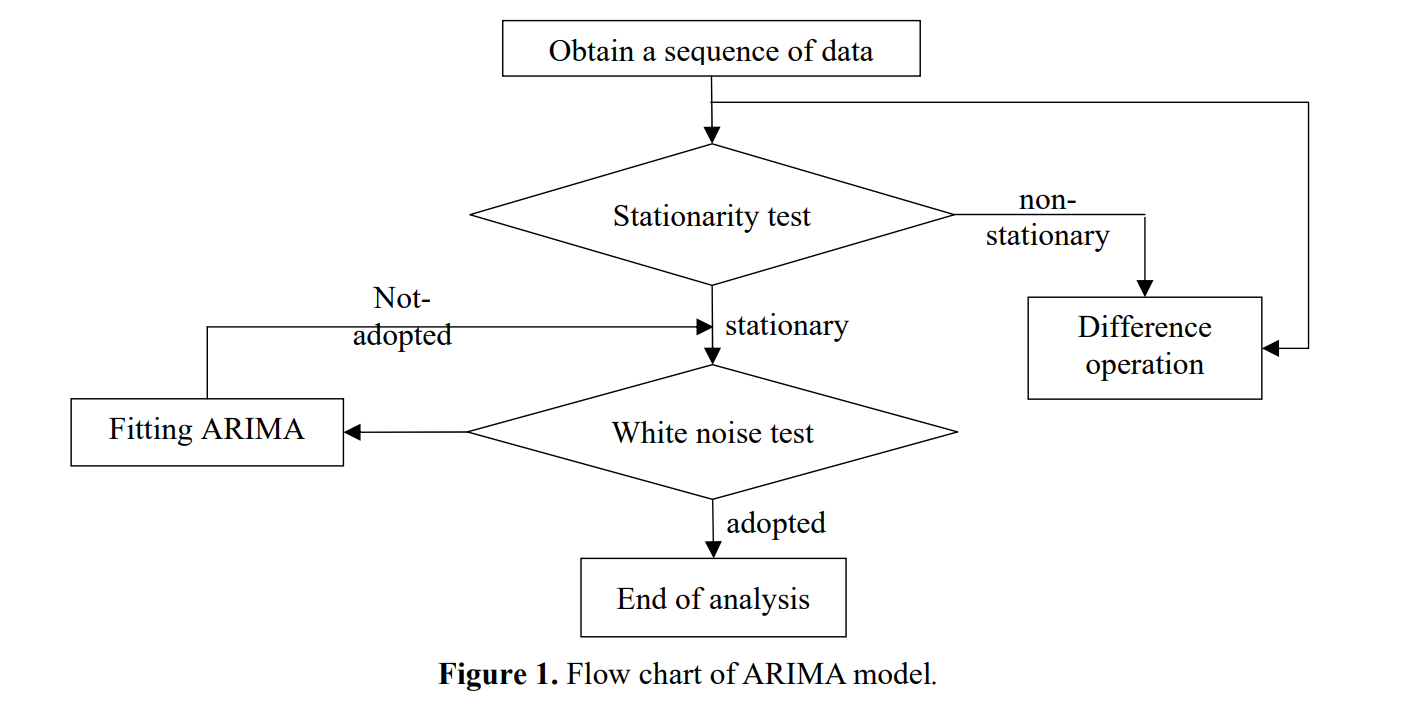

First, find lag value for the model. 



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

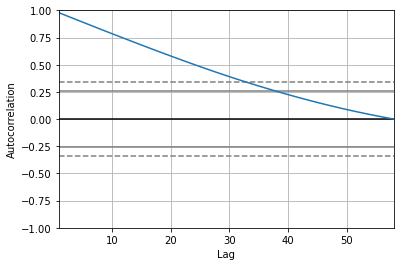

In [8]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_updated)

In [9]:
df = df_updated

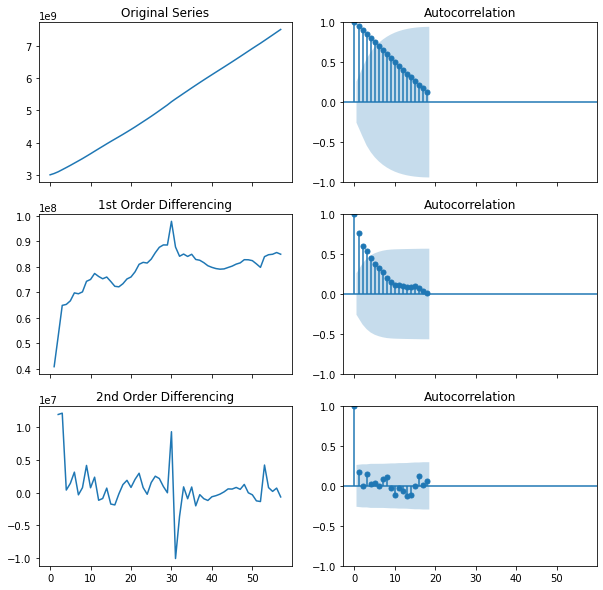

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True,figsize=(10, 10))
axes[0, 0].plot(df.Count); axes[0, 0].set_title('Original Series')
plot_acf(df.Count, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Count.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Count.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Count.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Count.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [12]:
!pip install pmdarima
from pmdarima import auto_arima
# stepwise_fit = auto_arima(df_updated['Count'], 
#                           suppress_warnings=True)           
# fit stepwise auto-ARIMA
stepwise_fit = auto_arima(df_updated['Count'], start_p=0, start_q=0,
                             max_p=10, max_q=10, m=1,     # m set to 1 as it cycle annual 
                             seasonal=False,
                             d=2, trace=True,   #second differecing
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1840.126, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1828.333, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1831.253, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1841.483, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1809.538, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1811.547, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1811.554, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1818.202, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1813.549, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1808.937, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1828.578, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1810.869, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1810.901, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1813.635, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -901.469
Date:                Sun, 06 Feb 2022   AIC                           1808.937
Time:                        13:04:48   BIC                           1815.013
Sample:                             0   HQIC                          1811.293
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0082      0.058     -0.142      0.887      -0.121       0.105
ar.L2         -0.0041      0.053     -0.077      0.938      -0.108       0.100
sigma2      5.802e+12   4.14e-15    1.4e+27      0.000     5.8e+12     5.8e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               159.95
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.48
Prob(H) (two-sided):                  0.20   Kurtosis:                        11.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+42. Standard errors may be unstable.
"""

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Count'],order=(2,2,0))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                   58
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -901.469
Date:                Sun, 06 Feb 2022   AIC                           1808.937
Time:                        13:04:48   BIC                           1815.013
Sample:                             0   HQIC                          1811.293
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0082      0.058     -0.142      0.887      -0.121       0.105
ar.L2         -0.0041      0.053     -0.077      0.938      -0.108       0.100
sigma2      5.802e+12   4.14e-15    1.4e+27      0.000     5.8e+12     5.8e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               159.95
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.48
Prob(H) (two-sided):                  0.20   Kurtosis:                        11.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+42. Standard errors may be unstable.
"""

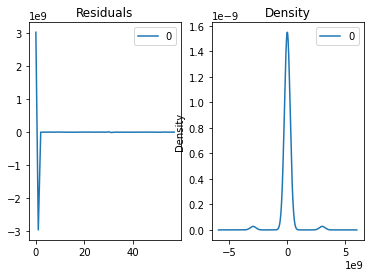

In [14]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

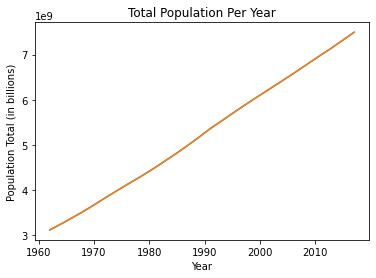

In [20]:
# Actual vs Fitted
plt.plot(df_updated.Year[2:],df_updated.Count[2:])
plt.plot(df_updated.Year[2:],model_fit.predict()[2:])
plt.xlabel("Year")
plt.ylabel("Population Total (in billions)")
plt.title("Total Population Per Year")
plt.show()

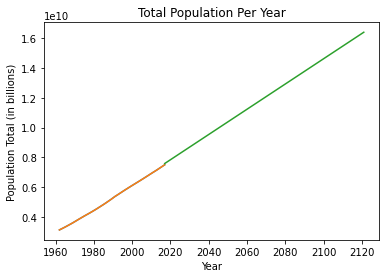

In [21]:
plt.plot(df_updated.Year[2:],df_updated.Count[2:])
plt.plot(df_updated.Year[2:],model_fit.predict()[2:])
plt.plot(range(2017,2122),model_fit.forecast(105))
plt.xlabel("Year")
plt.ylabel("Population Total (in billions)")
plt.title("Total Population Per Year")
plt.show()

In [22]:
model_fit.forecast(105)

58     7.578651e+09
59     7.663543e+09
60     7.748434e+09
61     7.833326e+09
62     7.918217e+09
           ...     
158    1.606780e+10
159    1.615269e+10
160    1.623758e+10
161    1.632248e+10
162    1.640737e+10
Name: predicted_mean, Length: 105, dtype: float64